In [1]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

In [2]:
%load_ext autoreload
%autoreload 2
from data.api_fetcher import ApiFetcher

In [3]:
api = ApiFetcher(starting_year=2019, ending_year=2025)
 

In [4]:
df_p = api.get_dataframe('playerstats', all=True)

In [6]:
df_g = api.get_dataframe('leaguegamelog', all=True)

In [10]:
print(df_p.columns)

Index(['season_year', 'player_id', 'player_name', 'nickname', 'team_id',
       'team_abbreviation', 'team_name', 'game_id', 'game_date', 'matchup',
       'wl', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm',
       'fta', 'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk',
       'blka', 'pf', 'pfd', 'pts', 'plus_minus', 'nba_fantasy_pts', 'dd2',
       'td3', 'wnba_fantasy_pts', 'gp_rank', 'w_rank', 'l_rank', 'w_pct_rank',
       'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank',
       'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'fta_rank', 'ft_pct_rank',
       'oreb_rank', 'dreb_rank', 'reb_rank', 'ast_rank', 'tov_rank',
       'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'pts_rank',
       'plus_minus_rank', 'nba_fantasy_pts_rank', 'dd2_rank', 'td3_rank',
       'wnba_fantasy_pts_rank', 'available_flag', 'min_sec', 'team_count',
       'season', 'ts_pct', 'ast_to_ratio', 'pts_per_fga', 'reb_per_min',
       'pts_ast_composite', 

In [11]:
df_g['date'] = pd.to_datetime(df_g['date'])
df_p['game_date'] = pd.to_datetime(df_p['game_date'])


df_g = df_g.sort_values('date').reset_index(drop=True)


In [12]:


# Create season column
# NBA seasons span two years (e.g., 2024-25 season starts in Oct 2024)
df_g['season'] = df_g['date'].apply(lambda x: x.year if x.month >= 10 else x.year - 1)

# Or if you want the format "22024":
df_g['season'] = df_g['date'].apply(lambda x: 
    int(f"2{x.year}" if x.month >= 10 else f"2{x.year-1}"))

In [ ]:
# ============================================================
# FINAL ELO SYSTEM - With Regression to Mean
# ============================================================
from collections import defaultdict
import numpy as np

class ELOSystem:
    """
    ELO system optimized for over/under predictions
    
    Features:
    - Dual ELO (offensive + defensive ratings)
    - Season-aware baseline (transfers knowledge across seasons)
    - Home court advantage (+2 points)
    - Regression to mean (ratings drift back toward 1500)
    - No data leakage (rolling baseline per season)
    """
    
    def __init__(self, k_factor=20, initial_rating=1500, home_advantage=2.0, regression_rate=0.005):
        """
        Initialize ELO system
        
        Args:
            k_factor: Learning rate (20 = moderate)
            initial_rating: Starting rating for all teams (1500 = average)
            home_advantage: Points added to home team (2.0 = typical)
            regression_rate: How fast ratings drift to mean (0.005 = slow, 0.01 = moderate)
        """
        self.k_factor = k_factor
        self.initial_rating = initial_rating
        self.home_advantage = home_advantage
        self.regression_rate = regression_rate
        
        # Core ELO ratings
        self.offensive_elo = defaultdict(lambda: initial_rating)
        self.defensive_elo = defaultdict(lambda: initial_rating)
        
        # Season tracking (for baseline calculation)
        self.season_totals = defaultdict(list)  # {season: [game_totals]}
        
        # History for analysis
        self.history = []
        
        print(f"✅ ELO System initialized")
        print(f"   K-factor: {k_factor}")
        print(f"   Initial rating: {initial_rating}")
        print(f"   Home advantage: +{home_advantage} points")
        print(f"   Regression rate: {regression_rate}")
        print(f"   ✨ Season-aware baseline (no leakage)")
        print(f"   ✨ Regression to mean (prevents runaway ratings)")
    
    def _get_key(self, team_id, season):
        """Create unique key for team-season"""
        return f"{season}_{team_id}"
    
    def get_offensive_rating(self, team_id, season):
        """Get team's offensive ELO"""
        key = self._get_key(team_id, season)
        return self.offensive_elo[key]
    
    def get_defensive_rating(self, team_id, season):
        """Get team's defensive ELO"""
        key = self._get_key(team_id, season)
        return self.defensive_elo[key]
    
    def get_baseline(self, season):
        """
        Get baseline for season (transfers from previous season if needed)
        
        Rules:
        1. If current season has <10 games → use previous season's average
        2. If current season has ≥10 games → use current season's average
        3. If no data at all → use default 110
        
        NO DATA LEAKAGE: Only uses games observed so far
        """
        # No data at all
        if not self.season_totals:
            return 110.0
        
        # Get all seasons in chronological order
        seasons = sorted(self.season_totals.keys())
        
        # Find current season's data
        if season in self.season_totals:
            current_games = self.season_totals[season]
            
            # If enough games in current season, use it
            if len(current_games) >= 10:
                return np.mean(current_games) / 2
        
        # Not enough current season data - use previous season
        if len(seasons) > 0:
            # Find the most recent season with data
            for prev_season in reversed(seasons):
                if prev_season != season and len(self.season_totals[prev_season]) > 0:
                    return np.mean(self.season_totals[prev_season]) / 2
            
            # If only current season exists but <10 games
            if season in seasons and len(self.season_totals[season]) > 0:
                return np.mean(self.season_totals[season]) / 2
        
        # Fallback
        return 110.0
    
    def apply_regression_to_mean(self, team_key):
        """
        Drift ratings back toward initial rating
        
        Why this helps:
        - Prevents ratings from becoming too extreme
        - Accounts for roster changes, injuries
        - Reflects uncertainty in long-term performance
        
        Example:
        - Team at 1600 rating → drifts toward 1500
        - Team at 1400 rating → drifts toward 1500
        - Rate = 0.005 means 0.5% movement per game
        """
        # Offensive rating regression
        current_off = self.offensive_elo[team_key]
        self.offensive_elo[team_key] = (
            current_off + (self.initial_rating - current_off) * self.regression_rate
        )
        
        # Defensive rating regression
        current_def = self.defensive_elo[team_key]
        self.defensive_elo[team_key] = (
            current_def + (self.initial_rating - current_def) * self.regression_rate
        )
    
    def predict_score(self, team_off_elo, opponent_def_elo, season):
        """
        Predict points based on ELO matchup
        
        Args:
            team_off_elo: Team's offensive ELO
            opponent_def_elo: Opponent's defensive ELO
            season: Season year (for baseline)
        
        Returns:
            Expected points
        """
        baseline = self.get_baseline(season)
        scale = 25  # Every 25 ELO points = 1 point difference
        
        expected = baseline + (team_off_elo - opponent_def_elo) / scale
        return expected
    
    def update_game(self, season, home_id, away_id, home_score, away_score, date):
        """
        Update ELO ratings after observing game result
        
        Process:
        1. Get current ratings
        2. Predict expected scores
        3. Calculate prediction errors
        4. Update ratings based on errors
        5. Apply regression to mean
        6. Record game for future baseline calculations
        """
        home_key = self._get_key(home_id, season)
        away_key = self._get_key(away_id, season)
        
        # Current ratings
        home_off = self.offensive_elo[home_key]
        home_def = self.defensive_elo[home_key]
        away_off = self.offensive_elo[away_key]
        away_def = self.defensive_elo[away_key]
        
        # Predict expected scores (with home advantage)
        expected_home = self.predict_score(home_off, away_def, season) + self.home_advantage
        expected_away = self.predict_score(away_off, home_def, season)
        
        # Calculate errors
        home_off_error = home_score - expected_home
        away_off_error = away_score - expected_away
        home_def_error = away_score - expected_away
        away_def_error = home_score - expected_home
        
        # Update offensive ratings
        self.offensive_elo[home_key] = home_off + self.k_factor * (home_off_error / 10)
        self.offensive_elo[away_key] = away_off + self.k_factor * (away_off_error / 10)
        
        # Update defensive ratings (inverse: allowing fewer = better)
        self.defensive_elo[home_key] = home_def - self.k_factor * (home_def_error / 10)
        self.defensive_elo[away_key] = away_def - self.k_factor * (away_def_error / 10)
        
        # Apply regression to mean (prevents runaway ratings)
        self.apply_regression_to_mean(home_key)
        self.apply_regression_to_mean(away_key)
        
        # Record game AFTER prediction (no leakage)
        total_score = home_score + away_score
        self.season_totals[season].append(total_score)
        
        # Record history
        self.history.append({
            'date': date,
            'season': season,
            'home_team': home_id,
            'away_team': away_id,
            'home_off_elo': self.offensive_elo[home_key],
            'home_def_elo': self.defensive_elo[home_key],
            'away_off_elo': self.offensive_elo[away_key],
            'away_def_elo': self.defensive_elo[away_key],
            'home_score': home_score,
            'away_score': away_score,
            'expected_home': expected_home,
            'expected_away': expected_away,
            'total_score': total_score,
            'expected_total': expected_home + expected_away,
            'total_error': total_score - (expected_home + expected_away),
            'baseline_used': self.get_baseline(season)
        })
    
    def predict(self, home_id, away_id, season):
        """
        Predict game scores
        
        Args:
            home_id: Home team ID
            away_id: Away team ID
            season: Season year
        
        Returns:
            dict with home_score, away_score, total_score
        """
        home_off = self.get_offensive_rating(home_id, season)
        home_def = self.get_defensive_rating(home_id, season)
        away_off = self.get_offensive_rating(away_id, season)
        away_def = self.get_defensive_rating(away_id, season)
        
        # Predict scores (with home advantage)
        home_score = self.predict_score(home_off, away_def, season) + self.home_advantage
        away_score = self.predict_score(away_off, home_def, season)
        
        return {
            'home_score': home_score,
            'away_score': away_score,
            'total_score': home_score + away_score,
            'home_off_elo': home_off,
            'home_def_elo': home_def,
            'away_off_elo': away_off,
            'away_def_elo': away_def,
            'baseline': self.get_baseline(season)
        }
    
    def get_season_summary(self):
        """Get summary statistics for all seasons"""
        import pandas as pd
        
        if not self.season_totals:
            return None
        
        summary = []
        for season in sorted(self.season_totals.keys()):
            totals = self.season_totals[season]
            if len(totals) > 0:
                summary.append({
                    'season': season,
                    'games': len(totals),
                    'avg_total': np.mean(totals),
                    'baseline': np.mean(totals) / 2,
                    'std_dev': np.std(totals),
                    'min': np.min(totals),
                    'max': np.max(totals)
                })
        
        return pd.DataFrame(summary)

print("✅ ELOSystem class defined (with regression to mean)")


🎯 EXAMPLE: PREDICT AN UPCOMING GAME

🏀 Matchup: Cleveland Cavaliers @ Oklahoma City Thunder

📊 Team Ratings:
   Oklahoma City Thunder:
      Offensive ELO: 1761
      Defensive ELO: 1544
   Cleveland Cavaliers:
      Offensive ELO: 1693
      Defensive ELO: 1462

🎯 Prediction:
   Oklahoma City Thunder: 124.5 points
   Cleveland Cavaliers: 116.0 points
   Total: 240.5 points
   Spread: Oklahoma City Thunder by 8.5


🚀 Starting ELO evaluation...

✅ ELO System initialized
   K-factor: 20
   Initial rating: 1500
   Home advantage: +2.0 points
   Regression rate: 0.005
   ✨ Season-aware baseline (no leakage)
   ✨ Regression to mean (prevents runaway ratings)
   Processed 200/7054 games...
   Processed 400/7054 games...
   Processed 600/7054 games...
   Processed 800/7054 games...
   Processed 1000/7054 games...
   Processed 1200/7054 games...
   Processed 1400/7054 games...
   Processed 1600/7054 games...
   Processed 1800/7054 games...
   Processed 2000/7054 games...
   Processed 2200/7054 games...
   Processed 2400/7054 games...
   Processed 2600/7054 games...
   Processed 2800/7054 games...
   Processed 3000/7054 games...
   Processed 3200/7054 games...
   Processed 3400/7054 games...
   Processed 3600/7054 games...
   Processed 3800/7054 games...
   Processed 4000/7054 games...
   Processed 4200/7054 games...
   Processed 4400/7054 games...
   Processed 4600/7054 games...
   Processed 4800/7054 ga

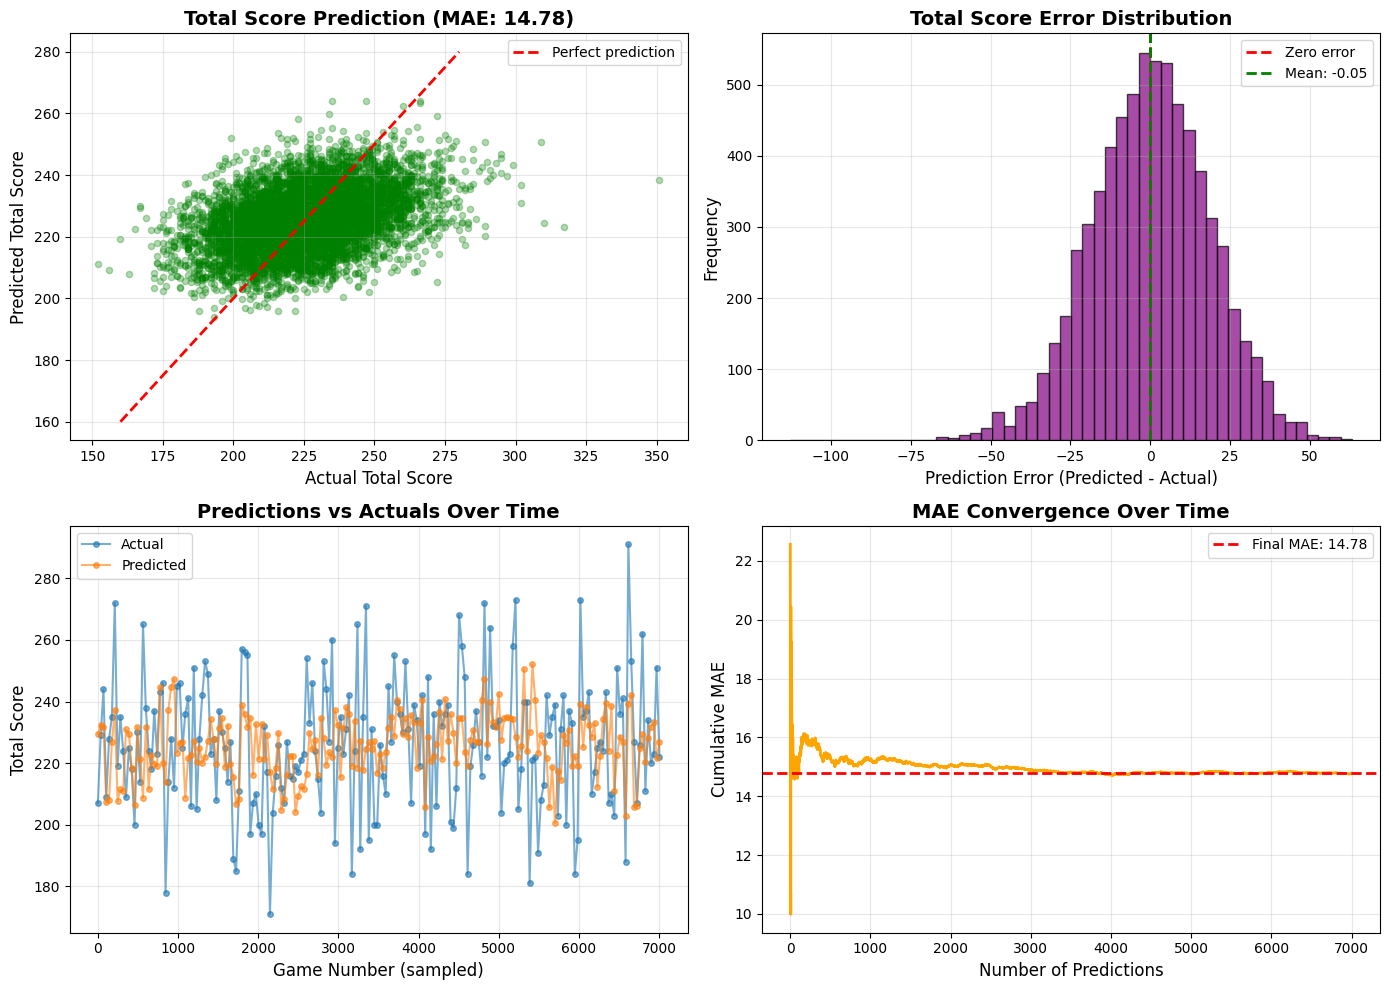


✅ Evaluation complete!


In [18]:
# ============================================================
# ELO SYSTEM EVALUATION
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🚀 Starting ELO evaluation...\n")

# Initialize ELO system (with regression to mean)
elo = ELOSystem(k_factor=20, initial_rating=1500, home_advantage=2.0, regression_rate=0.005)

# Storage for predictions
predictions = []
actuals = []
warmup_games = 50

# Process all games chronologically
for idx, game in df_g.iterrows():
    # PREDICT (using only past data)
    if idx >= warmup_games:
        pred = elo.predict(
            game['home_team_id'],
            game['away_team_id'],
            game['home_season_id']
        )
        
        predictions.append([
            pred['home_score'],
            pred['away_score'],
            pred['total_score']
        ])
        
        actuals.append([
            game['home_pts'],
            game['away_pts'],
            game['home_pts'] + game['away_pts']
        ])
    
    # UPDATE (add game to history)
    elo.update_game(
        game['home_season_id'],
        game['home_team_id'],
        game['away_team_id'],
        game['home_pts'],
        game['away_pts'],
        game['date']
    )
    
    # Progress
    if (idx + 1) % 200 == 0:
        print(f"   Processed {idx+1}/{len(df_g)} games...")

print(f"\n✅ Processed all {len(df_g)} games")
print(f"   Made predictions for {len(predictions)} games (after {warmup_games} game warmup)\n")

# ============================================================
# CALCULATE METRICS
# ============================================================
predictions = np.array(predictions)
actuals = np.array(actuals)

# Score prediction metrics
home_mae = np.mean(np.abs(predictions[:, 0] - actuals[:, 0]))
away_mae = np.mean(np.abs(predictions[:, 1] - actuals[:, 1]))
total_mae = np.mean(np.abs(predictions[:, 2] - actuals[:, 2]))
total_rmse = np.sqrt(np.mean((predictions[:, 2] - actuals[:, 2]) ** 2))

# Win prediction accuracy
pred_home_wins = predictions[:, 0] > predictions[:, 1]
actual_home_wins = actuals[:, 0] > actuals[:, 1]
win_accuracy = np.mean(pred_home_wins == actual_home_wins)

# Error distribution
total_errors = predictions[:, 2] - actuals[:, 2]
within_5 = np.mean(np.abs(total_errors) <= 5)
within_10 = np.mean(np.abs(total_errors) <= 10)
within_15 = np.mean(np.abs(total_errors) <= 15)

# Print results
print("="*60)
print("📊 ELO SYSTEM PERFORMANCE")
print("="*60)
print(f"\n🏀 Score Prediction:")
print(f"   Home MAE:  {home_mae:.2f} points")
print(f"   Away MAE:  {away_mae:.2f} points")
print(f"   Total MAE: {total_mae:.2f} points")
print(f"   Total RMSE: {total_rmse:.2f} points")

print(f"\n🎯 Win Prediction:")
print(f"   Accuracy: {win_accuracy:.1%}")

print(f"\n📈 Error Distribution:")
print(f"   Within ±5 points:  {within_5:.1%}")
print(f"   Within ±10 points: {within_10:.1%}")
print(f"   Within ±15 points: {within_15:.1%}")

print(f"\n📊 Prediction Bias:")
print(f"   Mean error: {np.mean(total_errors):.2f} (positive = over-predicting)")
print(f"   Std dev:    {np.std(total_errors):.2f}")
print("="*60)

# ============================================================
# SEASON SUMMARY
# ============================================================
print("\n" + "="*60)
print("📅 SEASON SUMMARY")
print("="*60)
season_summary = elo.get_season_summary()
if season_summary is not None:
    print(season_summary.to_string(index=False))
print("="*60)

# ============================================================
# VISUALIZATIONS
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Total Score Predictions
ax = axes[0, 0]
ax.scatter(actuals[:, 2], predictions[:, 2], alpha=0.3, s=20, color='green')
ax.plot([160, 280], [160, 280], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Total Score', fontsize=12)
ax.set_ylabel('Predicted Total Score', fontsize=12)
ax.set_title(f'Total Score Prediction (MAE: {total_mae:.2f})', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: Error Distribution
ax = axes[0, 1]
ax.hist(total_errors, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
ax.axvline(np.mean(total_errors), color='green', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(total_errors):.2f}')
ax.set_xlabel('Prediction Error (Predicted - Actual)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Total Score Error Distribution', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Prediction vs Actual Over Time
ax = axes[1, 0]
sample_indices = np.linspace(0, len(predictions)-1, 200).astype(int)
ax.plot(sample_indices, actuals[sample_indices, 2], 'o-', alpha=0.6, label='Actual', markersize=4)
ax.plot(sample_indices, predictions[sample_indices, 2], 'o-', alpha=0.6, label='Predicted', markersize=4)
ax.set_xlabel('Game Number (sampled)', fontsize=12)
ax.set_ylabel('Total Score', fontsize=12)
ax.set_title('Predictions vs Actuals Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Cumulative MAE
ax = axes[1, 1]
cumulative_mae = []
for i in range(1, len(total_errors)+1):
    cumulative_mae.append(np.mean(np.abs(total_errors[:i])))
ax.plot(cumulative_mae, linewidth=2, color='orange')
ax.axhline(total_mae, color='red', linestyle='--', linewidth=2, label=f'Final MAE: {total_mae:.2f}')
ax.set_xlabel('Number of Predictions', fontsize=12)
ax.set_ylabel('Cumulative MAE', fontsize=12)
ax.set_title('MAE Convergence Over Time', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")
